In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent))

In [3]:
import math
import time

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl
from torchvision.datasets import MNIST
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from real_nvp.model_creation import create_multiscale_flow
from utils import show_imgs

DATASET_PATH = Path(os.getcwd()).parent / "data"
MODELS_DIR = DATASET_PATH / "saved_models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", DEVICE)

Seed set to 42


Using device cuda:0


In [4]:
BATCH_SIZE = 1024
NUM_WORKERS = 4

MAX_EPOCHS = 300

In [5]:
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(), discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, persistent_workers=True)

In [6]:
def train_flow(
    flow_model: pl.LightningModule,
    model_name: str,
    ckeckpoint_dir: Path,
    train_loader: data.DataLoader,
    val_loader: data.DataLoader,
    test_loader: data.DataLoader,
    max_epochs: int = 200,
    check_val_every_n_epoch: int = 5,
    device: torch.device = DEVICE,
):
    model_dir = ckeckpoint_dir / model_name
    model_dir.mkdir(parents=True, exist_ok=True)

    callbacks = [
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
        LearningRateMonitor("epoch")
    ]

    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(
        default_root_dir=str(model_dir), 
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs, 
        gradient_clip_val=1.0,
        callbacks=callbacks,
        check_val_every_n_epoch=check_val_every_n_epoch,
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    result = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = model_dir / f"{model_name}.ckpt"
    if pretrained_filename.exists():
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow_model.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(
            model=flow_model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader
        )
    
    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(model=flow_model, dataloaders=val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(model=flow_model, dataloaders=test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow_model.import_samples}
    
    return flow_model, result

In [ ]:
msnist_acrhitechture = {
    "vardeq_layers": {
        "CouplingLayer": {
            "GatedConvNet": {
                "c_in": 2,
                "c_out": 2,
                "c_hidden": 16,
            },
            "mask": {
                "type": "checkerboard",
                "h": 28,
                "w": 28
            },
            "num_layers": 4
        },
    },
    "low_layers": {
        "CouplingLayer": {
            "GatedConvNet": {
                "c_in": 1,
                "c_hidden": 32,
            },
            "mask": {
                "type": "checkerboard",
                "h": 28,
                "w": 28
            }
        },
        "num_layers": 2
    },
    "after_squeeze_layers": {
        "CouplingLayer": {
            "GatedConvNet": {
                "c_in": 4,
                "c_hidden": 48,
            },
            "mask": {
                "type": "channel",
                "c_in": 4,
            }
        },
        "num_layers": 2
    },
    "after_split_layers": {
        "CouplingLayer": {
            "GatedConvNet": {
                "c_in": 8,
                "c_hidden": 64
            },
            "mask": {
                "type": "channel",
                "c_in": 8,
            }
        },
        "num_layers": 4
    }
}

mnist_config = {
    "architechture_config": msnist_acrhitechture,
    "hyperparameters": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "step_size": 1,
    }
}

In [7]:
multiscale_real_nvp_model = create_multiscale_flow(
    learning_rate=1e-3,
    gamma=0.99,
    step_size=1,
    example_input_array=train_set[0][0].unsqueeze(dim=0),
    visualize_samples_shape=(16, 8, 7, 7)
)

In [8]:
train_flow(
    flow_model=multiscale_real_nvp_model,
    model_name="multiscale_real_nvp_mnist_v1",
    ckeckpoint_dir=MODELS_DIR,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    max_epochs=MAX_EPOCHS,
    device=DEVICE
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Start training multiscale_real_nvp_mnist_v1



  | Name  | Type       | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------
0 | flows | ModuleList | 1.7 M  | train | ?        | ?        
--------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.847     Total estimated model params size (MB)
330       Modules in train mode
0         Modules in eval mode
/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Output nr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 1.2940053939819336 but got 1.2581830024719238.
Absolute difference: 0.035822391510009766 (up to 1e-05 allowed)
Relative difference: 0.027683340175095054 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xgeoadmin/miniconda3/envs/cuda-ml/lib/python3.10/site-packages/torch/jit/_trace.py:1307: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Expected 1.2946125268936157 but got 1.2628687620162964.
Absolute difference: 0.031743764877319336 (up to 1e-05 allowed)
Relative difference: 0.02451989627621444 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

(ImageFlow(
   (flows): ModuleList(
     (0): VariationalDequantization(
       (flows): ModuleList(
         (0-3): 4 x CouplingLayer(
           (network): GatedConvNet(
             (nn): Sequential(
               (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
               (1): GatedConv(
                 (net): Sequential(
                   (0): ConcatELU()
                   (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (2): ConcatELU()
                   (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                 )
               )
               (2): LayerNormChannels()
               (3): GatedConv(
                 (net): Sequential(
                   (0): ConcatELU()
                   (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (2): ConcatELU()
                   (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                 )
           

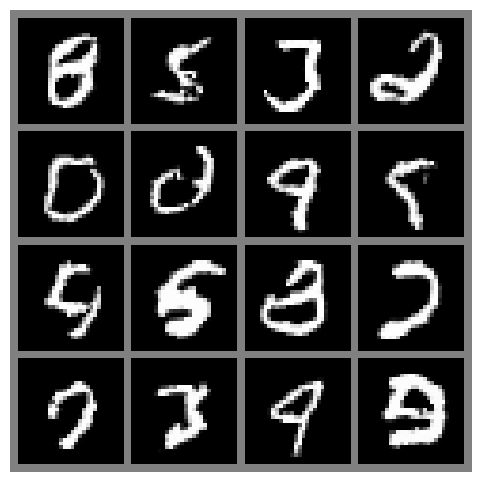

In [10]:
samples = multiscale_real_nvp_model.sample(img_shape=(16,8,7,7))
show_imgs(samples.cpu())

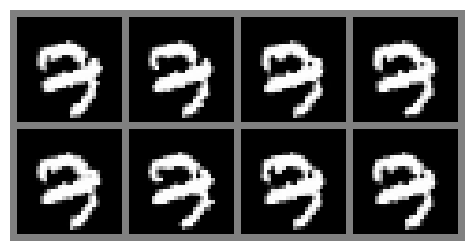

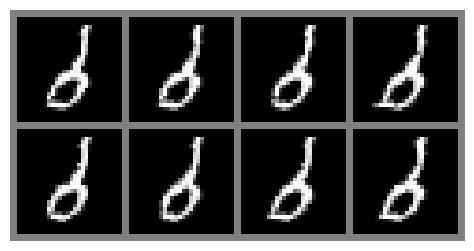

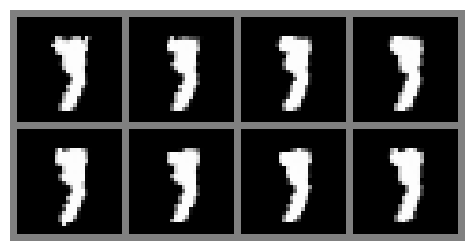

In [15]:
for _ in range(3):
    z_init = multiscale_real_nvp_model.prior.sample(sample_shape=[1,8,7,7])
    z_init = z_init.expand(8, -1, -1, -1)
    samples = multiscale_real_nvp_model.sample(img_shape=z_init.shape, z_init=z_init)
    show_imgs(samples.cpu())